In [1]:
import torch
from torchvision import transforms, models
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
from vcs2425 import ApplyColormap, evaluate, evaluate_topk, plot_training_curves, load_dataset_splits, calculate_accuracy
import time

# 1. Reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

# 2. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
COLOR_MAP = 'stacked'

# 3. Transforms
train_transform = transforms.Compose([
    transforms.Resize((342, 342), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop((299, 299)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    ApplyColormap(cmap=COLOR_MAP),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((342, 342), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop((299, 299)),
    ApplyColormap(cmap=COLOR_MAP),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [3]:
# 4. Load full dataset
train_dataset, val_dataset = load_dataset_splits('../../ILSVRC2012_depth', train_transform, val_transform)

BATCH_SIZE = 64

# 7. DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=8,
    pin_memory=True,  # Better memory management
    persistent_workers=True  # Keep workers alive between iterations
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=8,
    pin_memory=True,  # Better memory management
    persistent_workers=True  # Keep workers alive between iterations
)

In [4]:
import tqdm
from torch.optim import Optimizer
from typing import Tuple

def train(model: nn.Module, loader: DataLoader, criterion: nn.Module, optimizer: Optimizer, device: torch.device, model_name: str = None) -> Tuple[float, float]:
    model.train()
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    
    best_val_loss = float('inf')

    for images, labels in tqdm.tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        predictions = model(images)
        
        logits = predictions.logits
        aux_logits = predictions.aux_logits
        
        loss = criterion(logits, labels)
        
        if aux_logits is not None:
            aux_loss = criterion(aux_logits, labels)
            loss += 0.4 * aux_loss
        
        loss.backward()
        optimizer.step()
        acc = calculate_accuracy(logits, labels)
        
        if model_name is not None and loss.item() < best_val_loss:
            best_val_loss = loss.item()
            torch.save(model.state_dict(), f"{model_name}.pth")

        epoch_loss += loss.item()
        epoch_accuracy += acc.item()

    train_accuracy = epoch_accuracy / len(loader)
    train_loss = epoch_loss / len(loader)
    
    return train_loss, train_accuracy

# Training


We are going to train only the classifier

In [5]:
model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)

# Freeze all parameters
for param in model.parameters():
    param.requires_grad = True

model.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [6]:
# Print the number of trainable and frozen parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {frozen_params:,}")

Total parameters: 27,161,264
Trainable parameters: 27,161,264
Frozen parameters: 0


# Fine Tuning Classifier


In [7]:
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-4
REDUCE_LR_PATIENCE = 3
REDUCE_LR_FACTOR = 0.5

# 9. Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=REDUCE_LR_FACTOR, patience=REDUCE_LR_PATIENCE)

In [8]:
NUM_EPOCHS = 30
MODEL_NAME = 'inceptionv3_ft'

train_losses = []
train_accuracies = []
eval_losses = []
eval_accuracies = []


for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    train_loss, train_accuracy = train(model, 
        loader=train_loader, 
        criterion=criterion, 
        optimizer=optimizer,
        device=device,
        model_name=MODEL_NAME)

    train_time = time.time()

    eval_loss, eval_accuracy = evaluate(model, 
                                        loader=val_loader, 
                                        device=device,
                                        criterion=criterion)
    
    scheduler.step(eval_loss)
    
    eval_time = time.time()
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} Time: {(eval_time-start_time):.2f}s - \n"
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Took {(train_time-start_time):.2f}s, \n"
          f"Val Loss: {eval_loss:.4f}, Val Accuracy: {eval_accuracy:.4f}, Took {(eval_time-train_time):.2f}s \n")

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    eval_losses.append(eval_loss)
    eval_accuracies.append(eval_accuracy)

print("Training Complete!")

Epoch 1/30 Time: 221.63s - 
Train Loss: 4.8119, Train Accuracy: 0.3118, Took 206.84s, 
Val Loss: 2.6325, Val Accuracy: 0.4164, Took 14.79s 



Epoch 2/30 Time: 219.20s - 
Train Loss: 3.5258, Train Accuracy: 0.4491, Took 204.43s, 
Val Loss: 2.4427, Val Accuracy: 0.4489, Took 14.77s 



Epoch 3/30 Time: 216.17s - 
Train Loss: 2.9064, Train Accuracy: 0.5407, Took 202.19s, 
Val Loss: 2.3806, Val Accuracy: 0.4615, Took 13.98s 



Epoch 4/30 Time: 216.49s - 
Train Loss: 2.4608, Train Accuracy: 0.6079, Took 201.74s, 
Val Loss: 2.3507, Val Accuracy: 0.4708, Took 14.74s 



Epoch 5/30 Time: 217.92s - 
Train Loss: 2.0873, Train Accuracy: 0.6710, Took 203.28s, 
Val Loss: 2.3704, Val Accuracy: 0.4717, Took 14.64s 



Epoch 6/30 Time: 204.51s - 
Train Loss: 1.6188, Train Accuracy: 0.7611, Took 190.93s, 
Val Loss: 2.3093, Val Accuracy: 0.4851, Took 13.58s 



Epoch 7/30 Time: 199.53s - 
Train Loss: 1.4239, Train Accuracy: 0.7977, Took 185.98s, 
Val Loss: 2.3344, Val Accuracy: 0.4849, Took 13.55s 



Epoch 8/30 Time: 199.65s - 
Train Loss: 1.2828, Train Accuracy: 0.8252, Took 186.12s, 
Val Loss: 2.3573, Val Accuracy: 0.4841, Took 13.52s 



Epoch 9/30 Time: 200.12s - 
Train Loss: 1.1526, Train Accuracy: 0.8513, Took 186.62s, 
Val Loss: 2.3668, Val Accuracy: 0.4846, Took 13.50s 



Epoch 10/30 Time: 199.60s - 
Train Loss: 0.9612, Train Accuracy: 0.8908, Took 186.04s, 
Val Loss: 2.3589, Val Accuracy: 0.4843, Took 13.55s 



Epoch 11/30 Time: 200.41s - 
Train Loss: 0.8959, Train Accuracy: 0.9028, Took 186.85s, 
Val Loss: 2.3801, Val Accuracy: 0.4855, Took 13.56s 



Epoch 12/30 Time: 200.61s - 
Train Loss: 0.8410, Train Accuracy: 0.9129, Took 187.08s, 
Val Loss: 2.3917, Val Accuracy: 0.4830, Took 13.54s 



Epoch 13/30 Time: 199.57s - 
Train Loss: 0.7778, Train Accuracy: 0.9246, Took 186.02s, 
Val Loss: 2.4169, Val Accuracy: 0.4859, Took 13.55s 



Epoch 14/30 Time: 199.84s - 
Train Loss: 0.7072, Train Accuracy: 0.9364, Took 186.27s, 
Val Loss: 2.4124, Val Accuracy: 0.4811, Took 13.56s 



Epoch 15/30 Time: 200.72s - 
Train Loss: 0.6740, Train Accuracy: 0.9434, Took 187.18s, 
Val Loss: 2.4170, Val Accuracy: 0.4833, Took 13.54s 



Epoch 16/30 Time: 199.49s - 
Train Loss: 0.6492, Train Accuracy: 0.9473, Took 185.92s, 
Val Loss: 2.4200, Val Accuracy: 0.4828, Took 13.57s 



Epoch 17/30 Time: 199.50s - 
Train Loss: 0.6265, Train Accuracy: 0.9514, Took 185.94s, 
Val Loss: 2.4262, Val Accuracy: 0.4824, Took 13.56s 



Epoch 18/30 Time: 199.88s - 
Train Loss: 0.5903, Train Accuracy: 0.9574, Took 186.33s, 
Val Loss: 2.4225, Val Accuracy: 0.4838, Took 13.56s 



Epoch 19/30 Time: 199.86s - 
Train Loss: 0.5781, Train Accuracy: 0.9593, Took 186.30s, 
Val Loss: 2.4390, Val Accuracy: 0.4823, Took 13.57s 



Epoch 20/30 Time: 200.91s - 
Train Loss: 0.5674, Train Accuracy: 0.9611, Took 187.37s, 
Val Loss: 2.4354, Val Accuracy: 0.4827, Took 13.54s 



Epoch 21/30 Time: 199.73s - 
Train Loss: 0.5505, Train Accuracy: 0.9647, Took 186.19s, 
Val Loss: 2.4360, Val Accuracy: 0.4856, Took 13.54s 



Epoch 22/30 Time: 199.38s - 
Train Loss: 0.5382, Train Accuracy: 0.9666, Took 185.81s, 
Val Loss: 2.4437, Val Accuracy: 0.4806, Took 13.57s 



Epoch 23/30 Time: 199.16s - 
Train Loss: 0.5313, Train Accuracy: 0.9664, Took 185.60s, 
Val Loss: 2.4457, Val Accuracy: 0.4820, Took 13.57s 



Epoch 24/30 Time: 199.79s - 
Train Loss: 0.5248, Train Accuracy: 0.9682, Took 186.24s, 
Val Loss: 2.4531, Val Accuracy: 0.4816, Took 13.56s 



Epoch 25/30 Time: 199.22s - 
Train Loss: 0.5194, Train Accuracy: 0.9696, Took 185.70s, 
Val Loss: 2.4400, Val Accuracy: 0.4814, Took 13.52s 



Epoch 26/30 Time: 199.84s - 
Train Loss: 0.5112, Train Accuracy: 0.9704, Took 186.29s, 
Val Loss: 2.4507, Val Accuracy: 0.4814, Took 13.56s 



Epoch 27/30 Time: 200.03s - 
Train Loss: 0.5076, Train Accuracy: 0.9713, Took 186.47s, 
Val Loss: 2.4482, Val Accuracy: 0.4827, Took 13.56s 



Epoch 28/30 Time: 199.33s - 
Train Loss: 0.5057, Train Accuracy: 0.9716, Took 185.77s, 
Val Loss: 2.4474, Val Accuracy: 0.4827, Took 13.55s 



Epoch 29/30 Time: 199.65s - 
Train Loss: 0.5038, Train Accuracy: 0.9711, Took 186.10s, 
Val Loss: 2.4499, Val Accuracy: 0.4830, Took 13.56s 



Epoch 30/30 Time: 210.09s - 
Train Loss: 0.5022, Train Accuracy: 0.9715, Took 195.46s, 
Val Loss: 2.4531, Val Accuracy: 0.4832, Took 14.63s 

Training Complete!


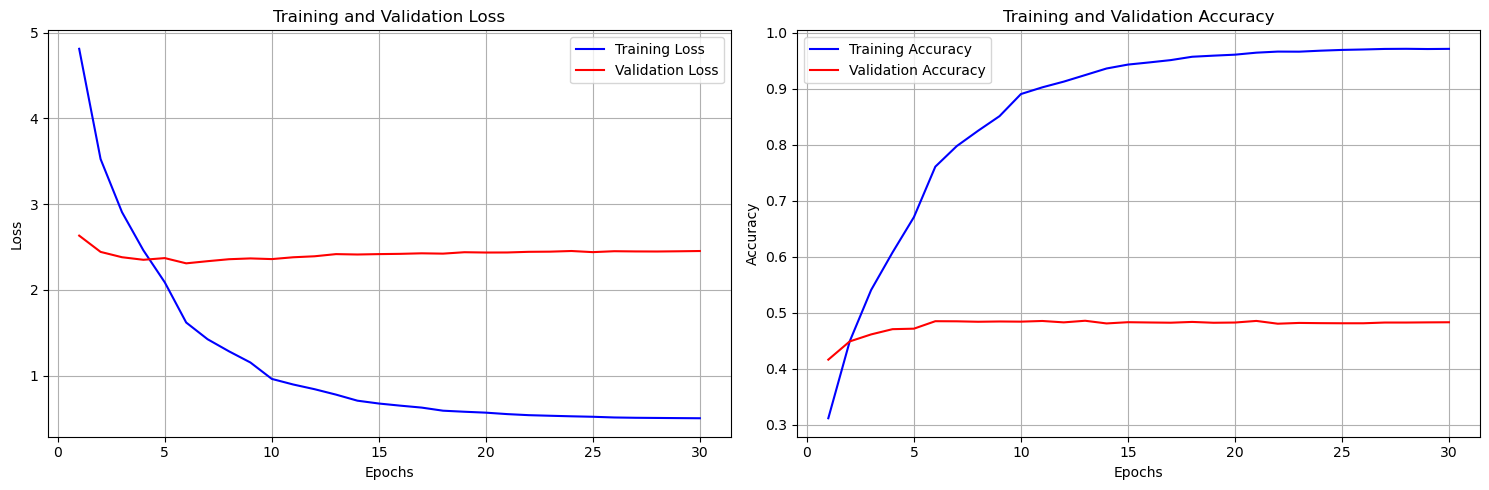

In [9]:
plot_training_curves(
    (train_losses, train_accuracies),
    (eval_losses, eval_accuracies),
)

# Evaluation metrics

In [10]:
# Load the best model weights
best_model_path = f"{MODEL_NAME}.pth"

# Load the saved model weights
model.load_state_dict(torch.load(best_model_path))
model.eval()  # Set the model to evaluation mode
print(f"Loaded best model from {best_model_path}")

# Evaluate the loaded model
val_loss, val_accuracy = evaluate(model, val_loader, criterion, device=device)
print(f"Best model - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Loaded best model from inceptionv3_ft.pth


Best model - Validation Loss: 2.4445, Validation Accuracy: 0.4848


In [11]:
top_1 = evaluate_topk(model, val_loader, k=1, device=device)
top_5 = evaluate_topk(model, val_loader, k=5, device=device)

print(f"Colormap: {COLOR_MAP}, Top-1 Accuracy: {top_1:.4f}, Top-5 Accuracy: {top_5:.4f}")

Colormap: stacked, Top-1 Accuracy: 0.4853, Top-5 Accuracy: 0.7453
